In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [28]:
raw = pd.read_csv('train.csv')

## Data Cleaning

In [3]:
raw.describe()

,index,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Anwesenheit
count,14241.000000,14236.000000,14234.000000,14237.000000,14241.000000,14241.000000
mean,3017.740117,21.005526,25.941076,628.058885,0.003995,0.256513
std,2235.616814,1.148923,4.581677,279.339892,0.000754,0.436724
min,1.000000,19.000000,16.745000,412.750000,0.002674,0.000000
25%,1234.000000,20.290000,22.675000,446.000000,0.003441,0.000000
50%,2420.000000,20.835000,25.726250,512.000000,0.003918,0.000000
75%,4583.000000,21.700000,28.650000,694.750000,0.004524,1.000000
max,8143.000000,24.408333,39.117500,2028.500000,0.006476,1.000000


In [4]:
raw[raw.isna().any(axis=1)]

,index,Datum,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Anwesenheit
487,488,2017-01-26 01:58:00,21.0500,25.0500,NaN,0.003861,0
1030,1031,2017-01-26 11:00:59,NaN,26.5000,1047.000000,0.004359,1
1599,1600,2017-01-26 20:30:00,21.2000,19.3900,NaN,0.003012,0
2507,2508,2017-01-27 11:38:00,21.7000,NaN,801.000000,0.003276,1
3000,3001,2017-01-27 19:51:00,20.5000,NaN,484.000000,0.002869,0
3764,3765,2017-01-28 08:35:00,NaN,19.4725,453.500000,0.002752,0
3981,3982,2017-01-28 12:11:59,22.8900,NaN,453.666667,0.003037,0
5706,5707,2017-01-29 16:57:00,19.4175,NaN,423.000000,0.003772,0
5911,5912,2017-01-29 20:22:00,19.3900,27.5000,NaN,0.003825,0
6537,6538,2017-01-30 06:48:00,NaN,26.2000,461.500000,0.003620,0


Pipeline zur Datenaufbereitung

In [5]:
def pipeline(raw):
    lead = raw.loc[:,:'Datum']
    tail = raw.loc[:,'Temperatur':]
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(tail)
    SimpleImputer()
    tail = pd.DataFrame(imp.transform(tail), columns = tail.columns)
    tail = tail.iloc[:14241,:]
    raw = pd.concat([lead, tail],axis=1)
    raw.drop(['index'], inplace=True, axis=1)
    raw['Datum'] = raw.Datum.astype('datetime64[ns]')
    raw['Minute'] = raw.Datum.dt.minute
    raw['Stunde'] = raw.Datum.dt.hour
    raw['Wochentag'] = raw.Datum.dt.day_name()
    try:
        Scaling = raw.drop(['Datum','Anwesenheit','Wochentag','Stunde', 'Minute'],axis=1)
    except:
        Scaling = raw.drop(['Datum','Wochentag','Stunde', 'Minute'],axis=1)
    scaler = StandardScaler()
    Scaling = pd.DataFrame(scaler.fit_transform(Scaling), columns = Scaling.columns)
    Rest = raw.drop(Scaling.columns,axis=1)
    raw = pd.concat([Scaling,Rest],axis=1)
    try:
        X = pd.get_dummies(raw.drop(['Datum','Anwesenheit'],axis = 1))
    except:
        X = pd.get_dummies(raw.drop(['Datum'],axis = 1))
    try:
        Y = raw['Anwesenheit']
    except:
        Y = None
    return X, Y

EDA: Suche nach Ausreißern, Betrachtung der Daten

<AxesSubplot:xlabel='Anwesenheit', ylabel='Temperatur'>

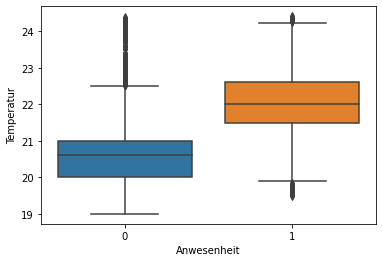

In [7]:
sns.boxplot(y=raw['Temperatur'],x=raw['Anwesenheit'])

<AxesSubplot:xlabel='Anwesenheit', ylabel='Luftfeuchtigkeit'>

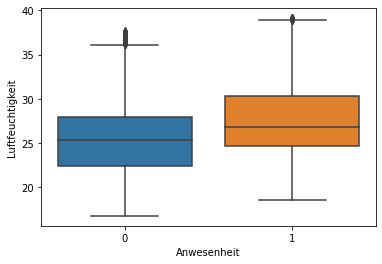

In [8]:
sns.boxplot(y=raw['Luftfeuchtigkeit'], x=raw['Anwesenheit'])

<AxesSubplot:xlabel='Anwesenheit', ylabel='CO2'>

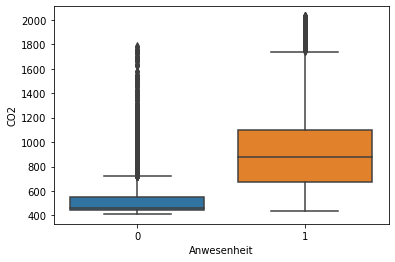

In [9]:
sns.boxplot(y=raw['CO2'],x=raw['Anwesenheit'])

<AxesSubplot:xlabel='Anwesenheit', ylabel='Wassergehalt'>

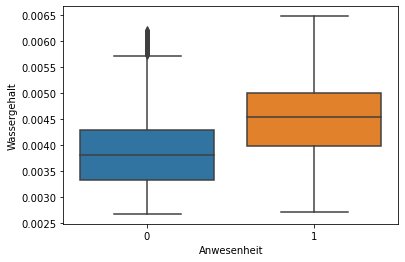

In [10]:
sns.boxplot(y=raw['Wassergehalt'], x=raw['Anwesenheit'])

Ausreißerdefinition nach Boxplots: 1.5 IQA Über oberer Box, da fallen sehr viele Werte drunter.

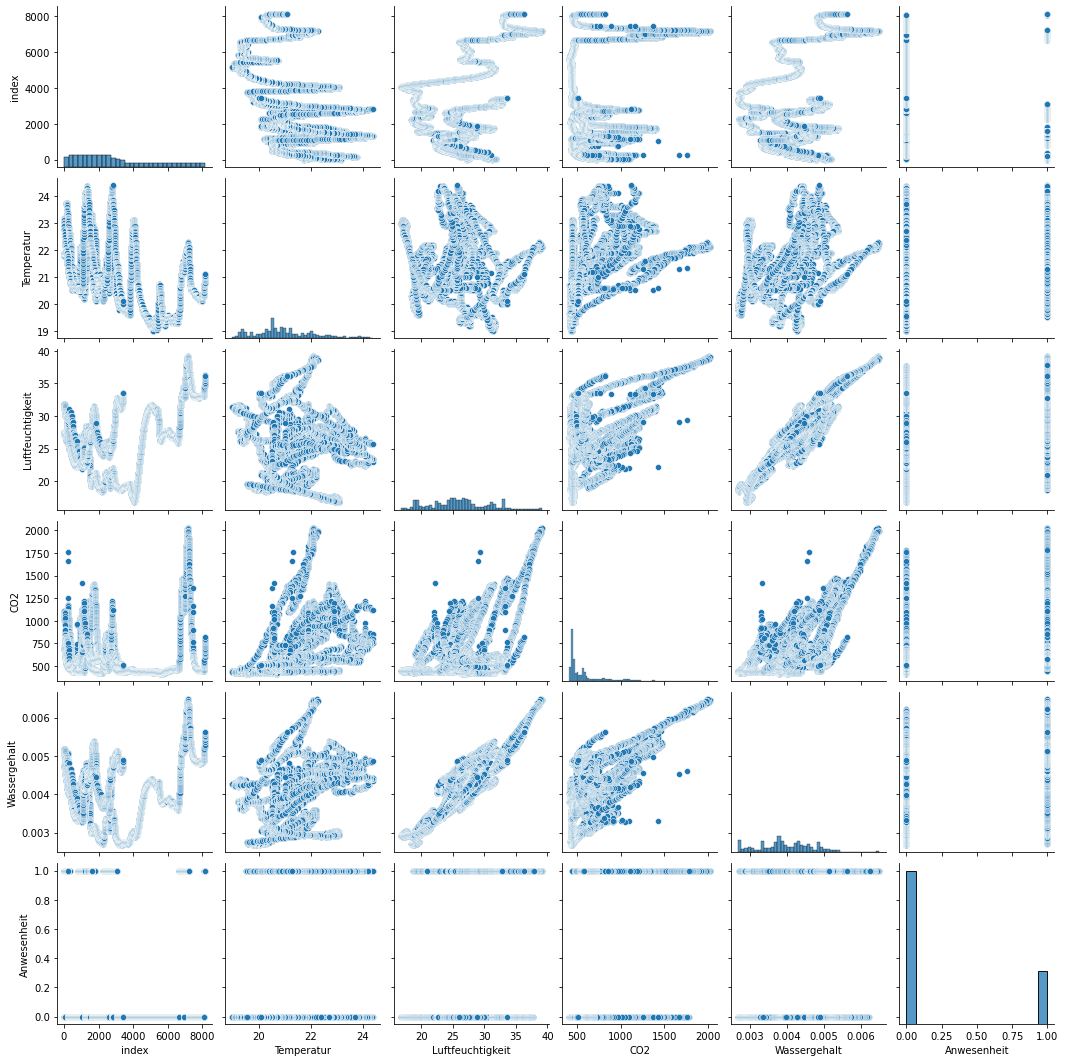

In [11]:
sns.pairplot(raw)

Rechtsschiefe Verteilung von CO2 -> hat auch die meisten Ausreißer

In [12]:
raw.corr()

,index,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Anwesenheit
index,1.000000,-0.443985,0.464987,0.016484,0.257450,-0.115893
Temperatur,-0.443985,1.000000,-0.042928,0.545890,0.345145,0.548536
Luftfeuchtigkeit,0.464987,-0.042928,1.000000,0.410984,0.921064,0.172865
CO2,0.016484,0.545890,0.410984,1.000000,0.615060,0.660468
Wassergehalt,0.257450,0.345145,0.921064,0.615060,1.000000,0.384524
Anwesenheit,-0.115893,0.548536,0.172865,0.660468,0.384524,1.000000


- Splate Anwesenheit sollte Angaben über Featurerelevanz geben: CO2,Temperatur,Wassergehalt, Luftfeuchtigkeit
- Wassergehalt abgeleitet aus Temperatur und Luftfeutigkeit -> nur hohe Korrelation mit Luftfeuchtigkeit

In [13]:
raw.groupby('Anwesenheit').mean()

,index,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt
Anwesenheit,,,,,
0,3169.919909,20.635407,25.475814,519.673805,0.003825
1,2576.656173,22.078577,27.289216,942.087819,0.004489


Erkennbare Relevanz aller Features für Unterscheidung Anwesenheit 1/0

<AxesSubplot:xlabel='Stunde', ylabel='count'>

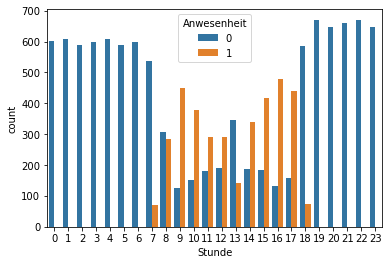

In [23]:
raw['Datum'] = raw.Datum.astype('datetime64[ns]')
raw['Stunde'] = raw.Datum.dt.hour
sns.countplot(data=raw, x='Stunde',hue='Anwesenheit')

In [26]:
raw['Wochentag'] = raw.Datum.dt.day_name()
raw.groupby('Wochentag').mean()

,index,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Anwesenheit,Stunde
Wochentag,,,,,,,
Friday,2621.000000,21.225981,23.721590,581.501042,0.003711,0.375000,11.494444
Monday,5004.012865,20.880780,29.626300,872.428748,0.004548,0.364671,13.549233
Saturday,3969.127689,20.576841,20.650503,443.632963,0.003075,0.000000,11.486468
Sunday,5409.500000,19.510642,29.201841,433.982812,0.004091,0.000000,11.494444
Thursday,1181.000000,21.600606,24.672862,664.274511,0.003945,0.271875,11.494444
Tuesday,3269.091857,21.109308,27.958959,694.482538,0.004336,0.324230,9.441410
Wednesday,1162.698403,21.302878,26.873286,594.390475,0.004219,0.255591,13.477955


Kein Pimmel ist am Wochenende da

# Random Forest
- Hpyerparameter: Baumtiefe (eigentlich nicht), Anzahl Bäume, Anzahl Features

In [29]:
rfor_x,rfor_y = pipeline(raw)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier

In [31]:
X_train, X_test, y_train, y_test = train_test_split(rfor_x, rfor_y, test_size=0.2, random_state=42)

Cross Validation for Hyperparameters: n_estimators, max_features, max_depth

In [32]:
from sklearn.model_selection import GridSearchCV 
param_grid = {'n_estimators':[10,100,200], #Default is 100
             'max_features':['sqrt','log2'], #Default ist sqrt, log2 other option
             'max_depth':[None,4,6]}, #Default is None, means depth until pure leaves are achieved
scores = ['accuracy', 'precision', 'recall']

gs = GridSearchCV(RandomForestClassifier(criterion = 'entropy', random_state=True),
                 param_grid = param_grid,
                 scoring = scores,
                 refit="recall", # needed for multi param search -> we decide on recall, because we have to minimize occasions, where present = 1 prediction = 0
                 return_train_score=True) # includes Train Scores in cv_results_
gs.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(criterion='entropy',
                                              random_state=True),
             param_grid=({'max_depth': [None, 4, 6],
                          'max_features': ['sqrt', 'log2'],
                          'n_estimators': [10, 100, 200]},),
             refit='recall', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall'])

Load CV results in DataFrame for visualization

In [33]:
df = pd.DataFrame(gs.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,...,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall
0,0.082211,0.007275,0.009772,0.000725,None,sqrt,10,"{'max_depth': None, 'max_features': 'sqrt', 'n...",0.987275,0.986836,...,0.979795,0.004517,5,0.999144,0.999144,0.997860,0.997432,0.998288,0.998373,0.000685
1,0.765300,0.007977,0.041688,0.003312,None,sqrt,100,"{'max_depth': None, 'max_features': 'sqrt', 'n...",0.992102,0.986398,...,0.983219,0.003320,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,1.772848,0.223980,0.087939,0.023514,None,sqrt,200,"{'max_depth': None, 'max_features': 'sqrt', 'n...",0.992102,0.986836,...,0.983562,0.004671,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,0.085774,0.008174,0.010853,0.001188,None,log2,10,"{'max_depth': None, 'max_features': 'log2', 'n...",0.987275,0.986836,...,0.979795,0.004517,5,0.999144,0.999144,0.997860,0.997432,0.998288,0.998373,0.000685
4,0.758053,0.035078,0.041227,0.007393,None,log2,100,"{'max_depth': None, 'max_features': 'log2', 'n...",0.992102,0.986398,...,0.983219,0.003320,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,1.510257,0.014607,0.072017,0.002018,None,log2,200,"{'max_depth': None, 'max_features': 'log2', 'n...",0.992102,0.986836,...,0.983562,0.004671,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,0.052400,0.001111,0.009263,0.000603,4,sqrt,10,"{'max_depth': 4, 'max_features': 'sqrt', 'n_es...",0.920140,0.916191,...,0.851027,0.020144,17,0.872432,0.859589,0.834332,0.860017,0.847603,0.854795,0.012898
7,0.483485,0.006404,0.030302,0.000464,4,sqrt,100,"{'max_depth': 4, 'max_features': 'sqrt', 'n_es...",0.937253,0.939447,...,0.914726,0.015968,13,0.910959,0.913955,0.919521,0.919949,0.919521,0.916781,0.003659
8,0.993758,0.041535,0.057566,0.002771,4,sqrt,200,"{'max_depth': 4, 'max_features': 'sqrt', 'n_es...",0.931110,0.931110,...,0.891096,0.022577,15,0.886558,0.887414,0.907106,0.894692,0.895976,0.894349,0.007407
9,0.051858,0.001388,0.008982,0.000016,4,log2,10,"{'max_depth': 4, 'max_features': 'log2', 'n_es...",0.920140,0.916191,...,0.851027,0.020144,17,0.872432,0.859589,0.834332,0.860017,0.847603,0.854795,0.012898


In [36]:
print(f"Ergebnis der CV: \nBestes Modell ist {gs.best_estimator_} \nmit Hyperparametern {gs.best_params_} und einem Recall von {gs.best_score_}")

Ergebnis der CV: 
Bestes Modell ist RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=200, random_state=True) 
mit Hyperparametern {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200} und einem Recall von 0.9835616438356165


Evaluation with best Hyperparameters on Test Data

In [35]:
rf = RandomForestClassifier(n_estimators=200, criterion='entropy', max_features = 'sqrt', random_state = True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Train Accuracy: ", rf.score(X_train, y_train), "Test Accuracy: ", rf.score(X_test, y_test))
print("Recall: ", recall_score(y_test, y_pred), "Precision: ", precision_score(y_test, y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
print("Feature Importance: \n", pd.Series(rf.feature_importances_, index=rfor_x.columns).sort_values(ascending=False)) 

Train Accuracy:  1.0 Test Accuracy:  0.9936819936819937
Recall:  0.9863574351978172 Precision:  0.9890560875512996
Confusion Matrix: 
 [[2108    8]
 [  10  723]]
Feature Importance: 
 CO2                    0.283494
Stunde                 0.239889
Temperatur             0.201969
Wassergehalt           0.093032
Luftfeuchtigkeit       0.075168
Minute                 0.035423
Wochentag_Friday       0.014878
Wochentag_Saturday     0.014519
Wochentag_Thursday     0.014075
Wochentag_Sunday       0.011358
Wochentag_Monday       0.006243
Wochentag_Tuesday      0.005844
Wochentag_Wednesday    0.004106
dtype: float64


ROC-Curve

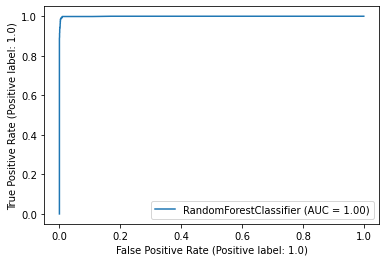

In [37]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()

Calculuate FPR & TPR for comparability with other models
- Calulate Predictions for every Threshold
- safe predictions in DataFrame + Labels
- calulate tp,fn,fp,tn rates for every threshhold and retrieve FPR and FNR

In [184]:
probs = rf.predict_proba(X_test)
preds = []
for threshold in np.arange(0,1.01,0.01):
    preds.append(probs > threshold)

In [235]:
calc = pd.DataFrame(index=np.arange(0,2849,1))
for ind, el in enumerate(preds):
    calc[ind] = pd.DataFrame(el).drop(0, axis =1).astype(int)
calc['Anwesenheit'] = y_test.reset_index(drop=True).astype(int)
#calc = calc.astype(bool)

Einfache Lösung

In [ ]:
l = []
for el in np.arange(0,101,1):
    tn, fp, fn, tp = confusion_matrix(calc['Anwesenheit'], calc[el]).ravel()
    tpr = tp / (tp+fn)
    fpr = fp / (fp+tn)
    tup = np.array([tpr,fpr])
    l.append(tup)
rates_ = pd.DataFrame(l, columns = ['TPR','FPR'])
rates_['Threshold'] = np.arange(0,1.01,0.01)

Etwas umständlich

In [266]:
l = []
calc = calc.astype(bool)
for el in np.arange(0,101,1):
    calc[f'tp{el}'] = calc[el] & calc['Anwesenheit']
    calc[f'fn{el}'] = ~calc[el] & calc['Anwesenheit']
    calc[f'fp{el}'] = calc[el] & ~calc['Anwesenheit']
    calc[f'tn{el}'] = ~calc[el] & ~calc['Anwesenheit']
    tpr = calc[f'tp{el}'].sum() /(calc[f'tp{el}'].sum()+calc[f'fn{el}'].sum())
    fpr = calc[f'fp{el}'].sum() /(calc[f'fp{el}'].sum()+calc[f'tn{el}'].sum())
    tup = np.array([tpr,fpr])
    l.append(tup)
rates = pd.DataFrame(l, columns = ['TPR','FPR'])
rates['Threshold'] = np.arange(0,1.01,0.01)

In [284]:
rates[['Threshold','TPR','FPR']].to_csv('ROC_RF.csv', index=False)
rates_[['Threshold','TPR','FPR']].to_csv('ROC_RF2.csv', index=False)

Last Step: Use model on unseen Data (test.csv)

In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
test.shape

In [ ]:
X_val,trash = pipeline(test)

In [ ]:
X_train, y_train = pipeline(raw)

In [ ]:
X_train.columns

In [ ]:
X_val.columns

Need to add Columns to Test Data that represent non occuring days  in Test Data

In [ ]:
X_val['Wochentag_Friday'] = 0
X_val['Wochentag_Thursday'] = 0

Reorder Columns as they were in Train Data

In [ ]:
cols =['Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Wassergehalt', 'Minute',
       'Stunde', 'Wochentag_Friday', 'Wochentag_Monday', 'Wochentag_Saturday',
       'Wochentag_Sunday', 'Wochentag_Thursday', 'Wochentag_Tuesday',
       'Wochentag_Wednesday']

Add Prediction Column

In [ ]:
X_val['Vorhersage'] = rf.predict(X_val[cols])

In [ ]:
X_val.to_csv('RandomForest.csv', index=False)

In [ ]:
## Unwichtig!! Hyperparametersuche ohne CV

from itertools import product
n_estimators = [10,100,200] #Default is 100
max_features = ['sqrt','log2'] #Default ist sqrt, log2 other option
max_depth = [None,2,4,6] #Default is None, means depth to pure leaves

for e, f, d in product(n_estimators, max_features, max_depth):
    rf = RandomForestClassifier(n_estimators = e,
                                criterion = 'entropy',
                                max_features = f,
                                max_depth = d,
                                random_state = None,
                                oob_score = True) # When given, keeps Bootstrap & Feature selection constant -> meine Logik: sollte auf False bleiben, damit CV erspart bleibt? (random Bootstraps bei jedem Baum?)
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    print(f'\n \n RandomForest mit Hyperparametern: \n n_trees: {e}, n_features: {f}, Tiefe: {d}')
    print("Train Accuracy: ", rf.score(X_train, y_train), "Test Accuracy: ", rf.score(X_test, y_test))
    print("Recall: ", recall_score(y_test, y_pred), "Precision: ", precision_score(y_test, y_pred))
    print("Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
    print("Feature Importance: \n", pd.Series(rf.feature_importances_, index=rfor_x.columns).sort_values(ascending=False)) 